# Многоклассовая классификация и множественная классификация/регрессия
Винник Екатерина Петровна, 22.М04

# Задача

- [ ] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [ ] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [ ] Замерить время обучения каждой модели для каждой стратегии.
- [ ] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [ ] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [ ] (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [ ] (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.

## Multiclass classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения


In [2]:
df = pd.read_csv('./glass_types.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### EDA

Посмотрим, сколько каких значений принимает признак Type.

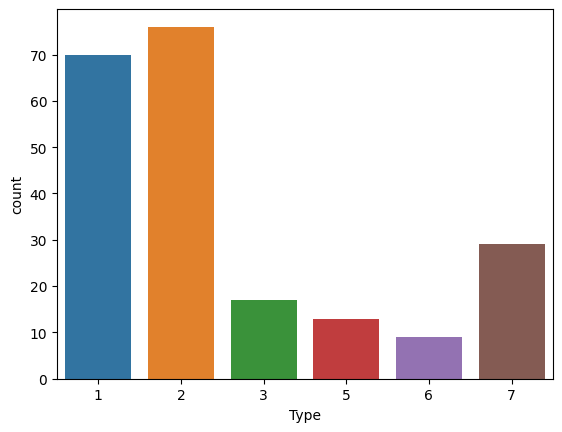

In [3]:
sns.countplot(x="Type", data=df)
plt.show()

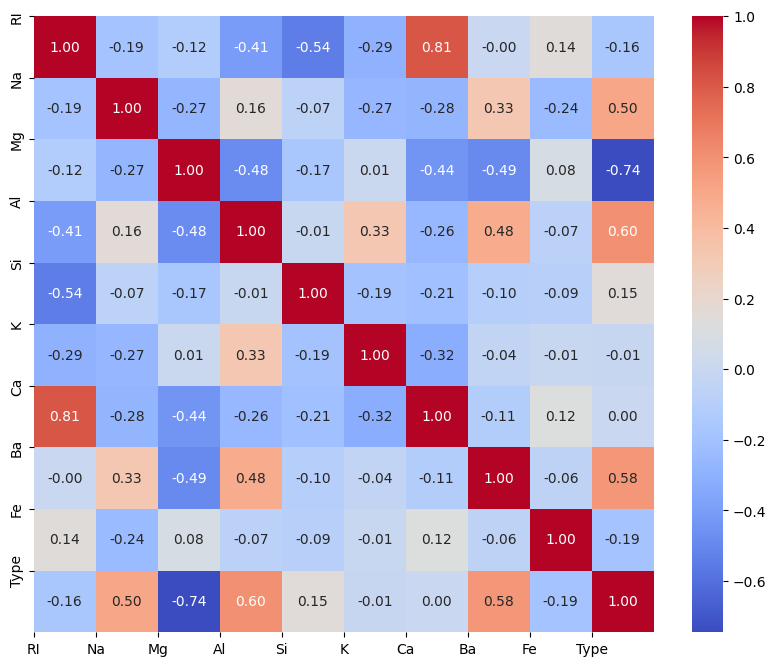

In [4]:
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

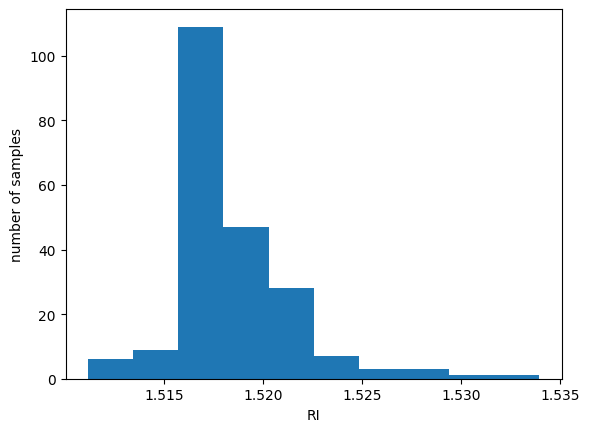

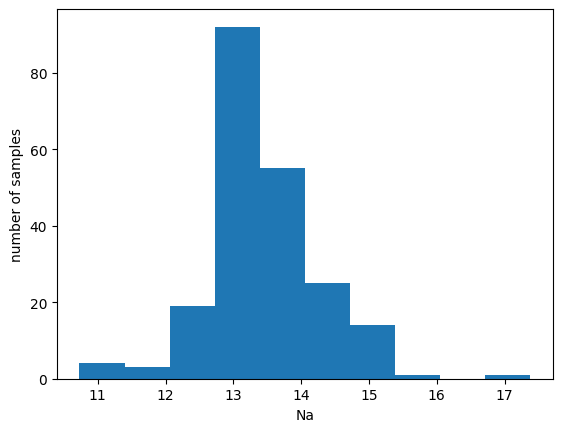

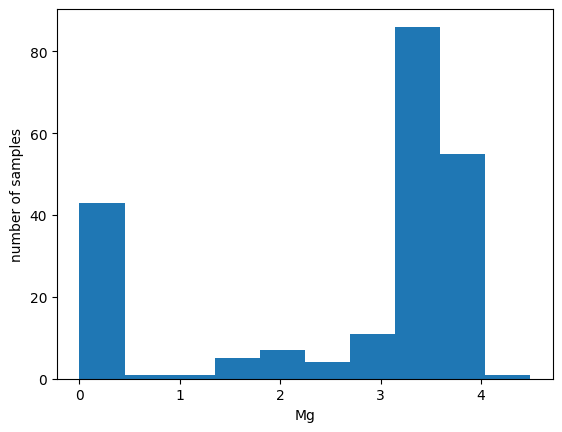

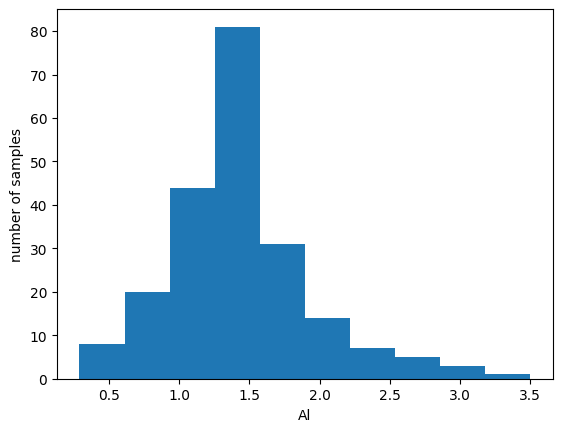

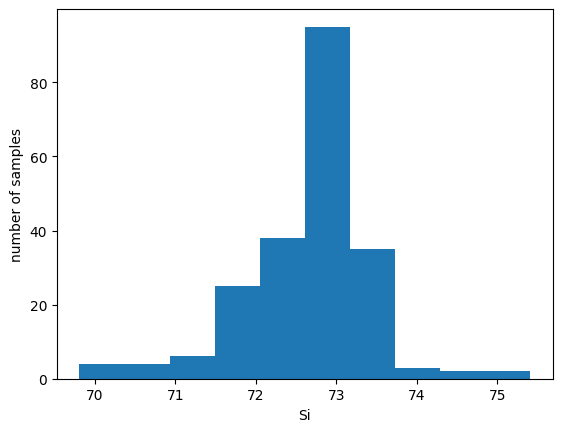

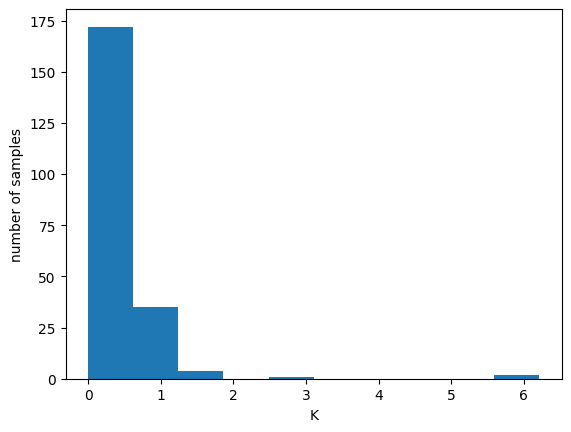

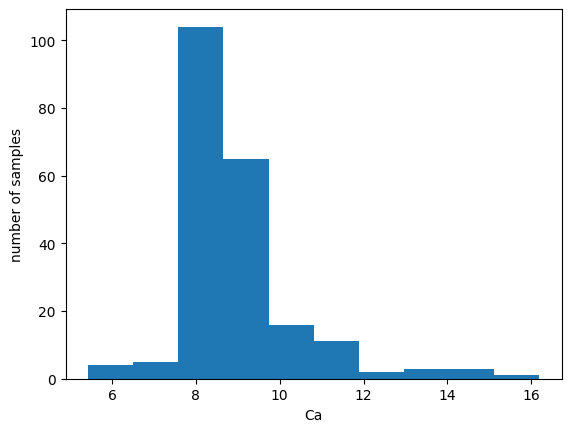

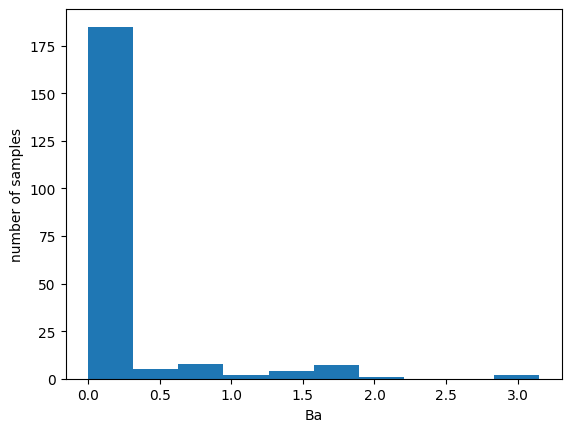

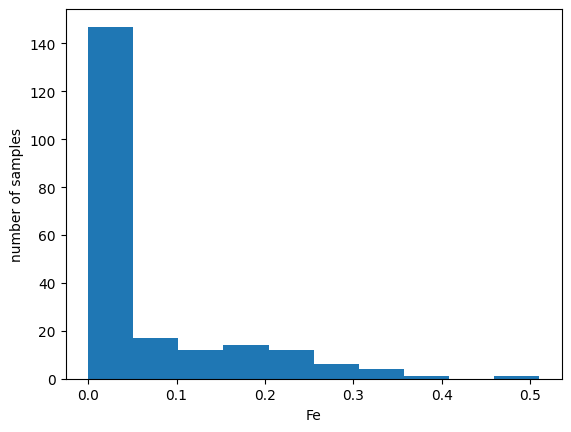

In [5]:
#numerical features
numerical = [
    'RI',
    'Na',
    'Mg',
    'Al',
    'Si',
    'K',
    'Ca',
    'Ba',
    'Fe'
]

for i in df[numerical].columns:
    plt.hist(df[numerical][i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('number of samples')
    plt.show()    

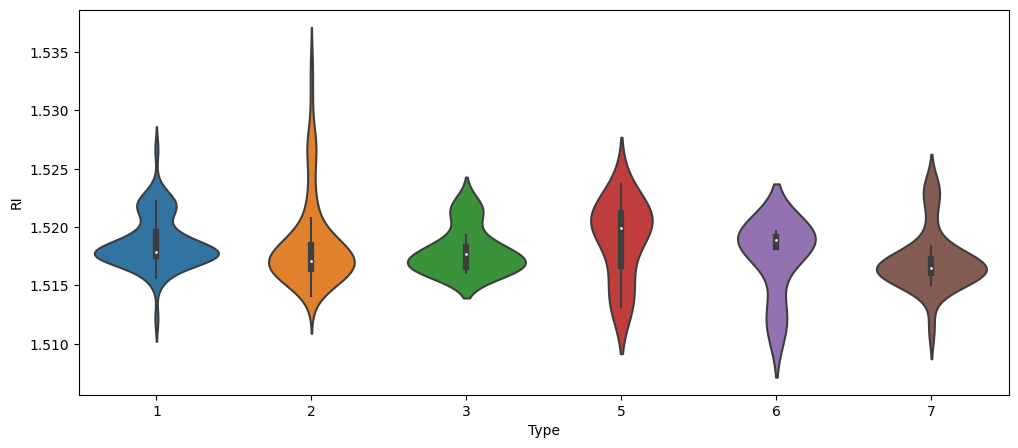

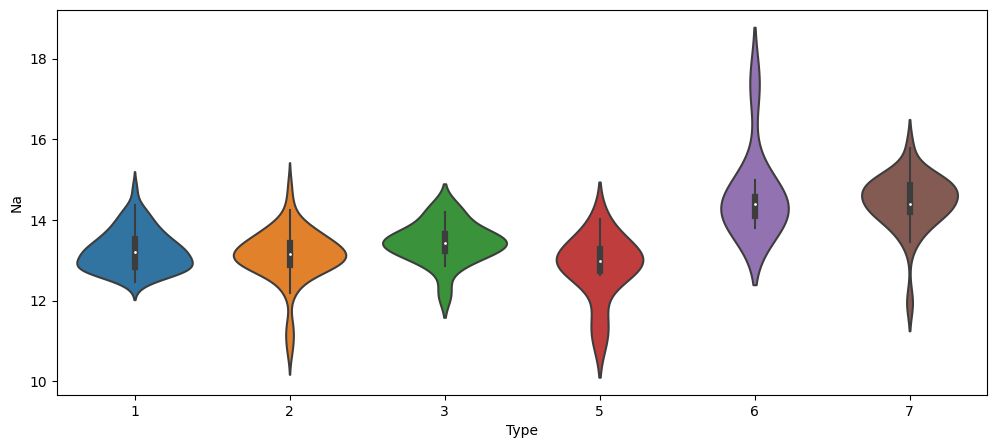

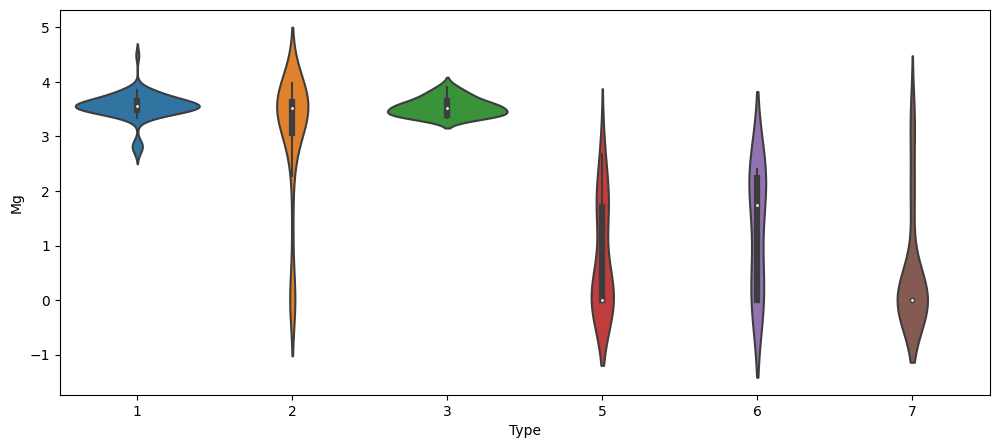

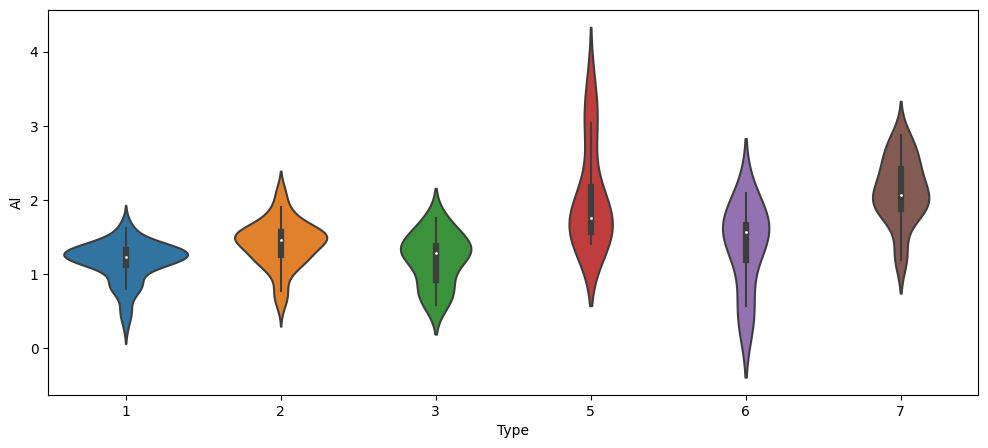

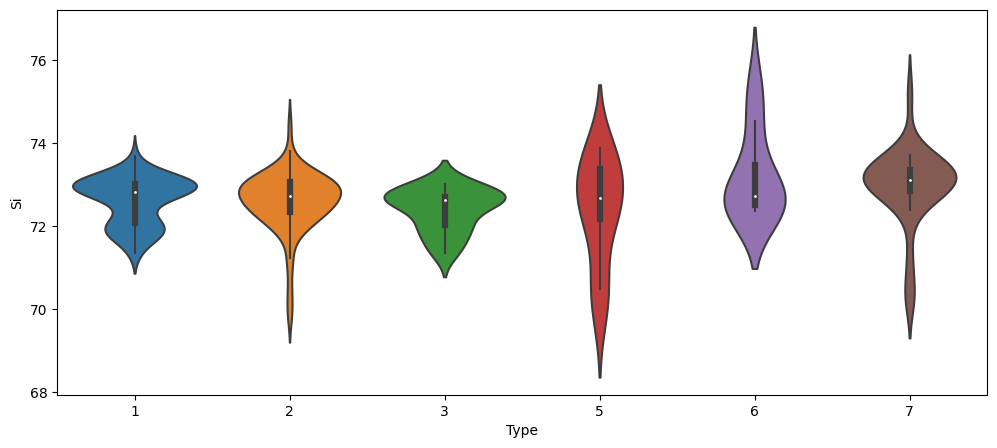

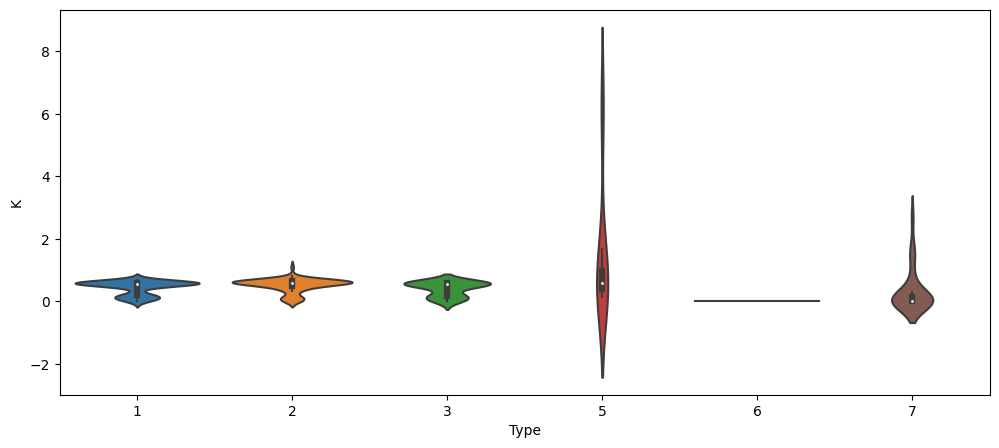

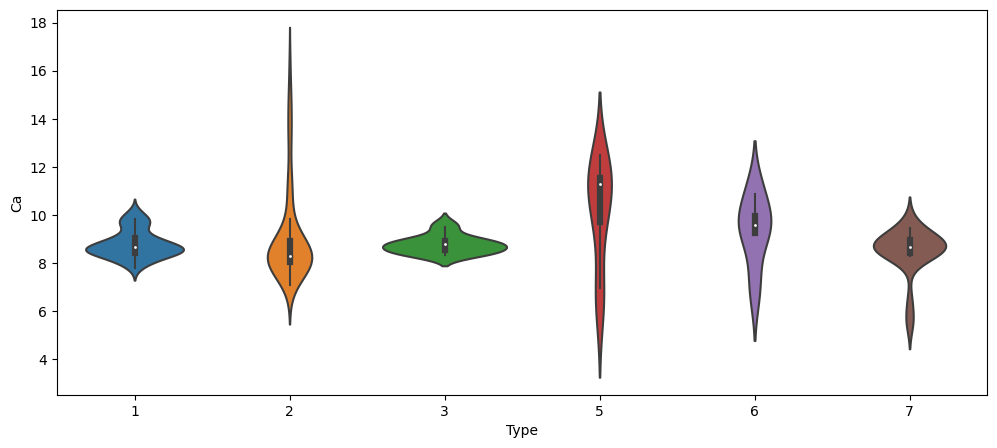

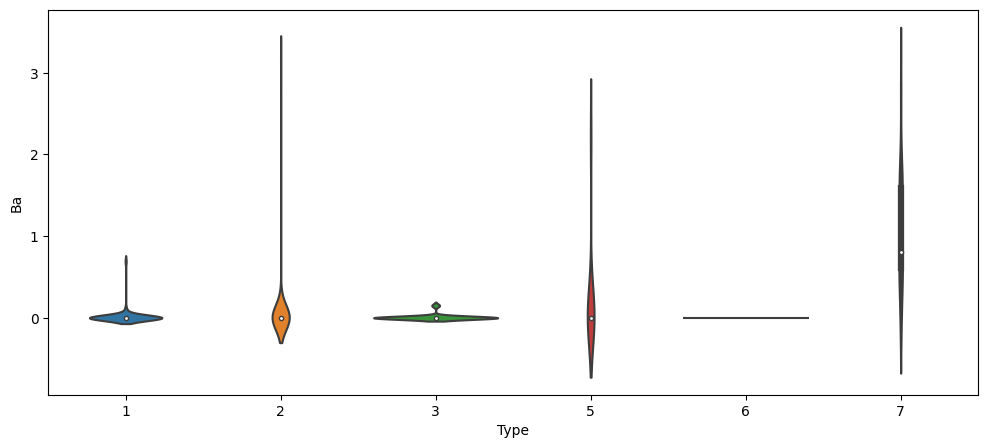

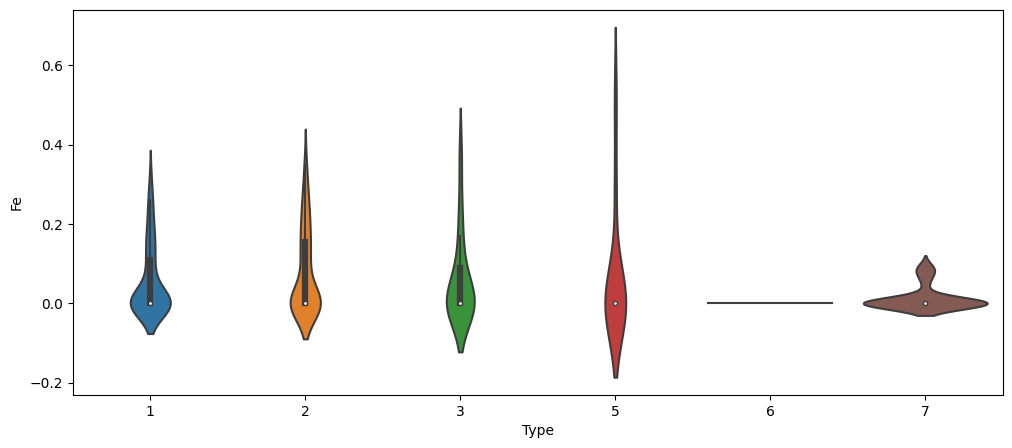

In [6]:
for i in df[numerical].columns:
    sns.violinplot(data=df,x="Type", y=i, split=True)
    fig = plt.gcf()
    fig.set_size_inches(12, 5)
    plt.show()


In [7]:
df['Ba'].value_counts()

0.00    176
0.64      2
1.57      2
0.09      2
1.59      2
0.11      2
3.15      1
0.81      1
1.64      1
1.06      1
0.54      1
2.88      1
1.38      1
1.55      1
0.67      1
1.71      1
0.56      1
0.63      1
0.53      1
0.66      1
0.61      1
0.27      1
0.69      1
0.40      1
0.14      1
0.76      1
1.68      1
1.63      1
1.19      1
0.24      1
2.20      1
0.15      1
0.06      1
1.67      1
Name: Ba, dtype: int64

In [8]:
df['Fe'].value_counts()

0.00    144
0.24      7
0.17      7
0.09      6
0.10      5
0.11      4
0.16      3
0.28      3
0.12      3
0.22      3
0.14      3
0.07      3
0.19      2
0.15      2
0.08      2
0.06      1
0.21      1
0.05      1
0.51      1
0.37      1
0.35      1
0.25      1
0.18      1
0.34      1
0.29      1
0.30      1
0.20      1
0.32      1
0.26      1
0.03      1
0.31      1
0.01      1
Name: Fe, dtype: int64

### Разбиение данных с использованием train_test_split и масштабирование

In [9]:
X = df.drop('Type', axis = 1).values
y = df['Type'].values.reshape(-1,1)
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (160, 9)
Shape of X_test:  (54, 9)
Shape of y_train:  (160, 1)
Shape of y_test (54, 1)


### Обучение моделей

#### Logistic regression

In [10]:
# Fitting Logistic Regression to the Training set
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier

classifier_lr = LogisticRegression()
steps = [
    ('scalar', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
]

lr_pipe = Pipeline(steps)

In [11]:
parameters = { 'model__C' : [1,10,100,1000,10000],
               'model__fit_intercept' : [True],
               'model__multi_class' : ['auto'],
               'model__tol' : [0.0001],
               'model__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'model__n_jobs' : [-1],
               'model__max_iter' : [5000]
}

model = GridSearchCV(lr_pipe, parameters, scoring='roc_auc', cv = 3)

classifier_lr_ovo = OneVsOneClassifier(model)
classifier_lr_ovo = classifier_lr_ovo.fit(X_train, y_train.ravel())

classifier_lr_ovr = OneVsRestClassifier(model)
classifier_lr_ovr = classifier_lr_ovr.fit(X_train, y_train.ravel())

classifier_lr_oc = OutputCodeClassifier(model)
classifier_lr_oc = classifier_lr_oc.fit(X_train, y_train.ravel())

In [12]:
from sklearn.metrics import accuracy_score

# 1 - 1
y_pred_lr_train = classifier_lr_ovo.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set using ovo classifier: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr_ovo.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set using ovo classifier: ", accuracy_lr_test)

# 1 - rest
y_pred_lr_train = classifier_lr_ovr.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set using ovr classifier: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr_ovr.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set using ovr classifier: ", accuracy_lr_test)

# output code
y_pred_lr_train = classifier_lr_oc.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set using output code classifier: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr_oc.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set using output code classifier: ", accuracy_lr_test)

Training set using ovo classifier:  0.7
Test set using ovo classifier:  0.6666666666666666
Training set using ovr classifier:  0.675
Test set using ovr classifier:  0.7407407407407407
Training set using output code classifier:  0.65625
Test set using output code classifier:  0.6481481481481481


#### KNN

In [13]:
# Fitting classifier to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier()
steps = [
    ('scalar', StandardScaler()),
    ('model', KNeighborsClassifier())
]
knn_pipe = Pipeline(steps)

In [14]:
parameters = { 'model__algorithm' : ['brute'],
               'model__leaf_size' : [30,50,70,90,110],
               'model__metric' : ['minkowski'],
               'model__p' : [1],
               'model__n_neighbors' : [3,5,11,19],
               'model__weights' : ['uniform', 'distance'],
               'model__n_jobs' : [-1]
}
classifier_knn = GridSearchCV(knn_pipe, parameters, scoring='roc_auc', cv = 3)
classifier_knn = classifier_knn.fit(X_train, y_train.ravel())

classifier_knn_ovo = OneVsOneClassifier(classifier_knn)
classifier_knn_ovo = classifier_knn_ovo.fit(X_train, y_train.ravel())

classifier_knn_ovr = OneVsRestClassifier(classifier_knn)
classifier_knn_ovr = classifier_knn_ovr.fit(X_train, y_train.ravel())

classifier_knn_oc = OutputCodeClassifier(classifier_knn)
classifier_knn_oc = classifier_knn_oc.fit(X_train, y_train.ravel())

In [15]:
# 1 - 1
y_pred_knn_train = classifier_knn_ovo.predict(X_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set using ovo classifier: ", accuracy_knn_train)
 
y_pred_knn_test = classifier_knn_ovo.predict(X_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set using ovo classifier: ", accuracy_knn_test)

# 1 - rest
y_pred_knn_train = classifier_knn_ovr.predict(X_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set using ovr classifier:  ", accuracy_knn_train)

y_pred_knn_test = classifier_knn_ovr.predict(X_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set using ovo classifier: ", accuracy_knn_test)

# output code
y_pred_knn_train = classifier_knn_oc.predict(X_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set using oc classifier: ", accuracy_knn_train)

y_pred_knn_test = classifier_knn_oc.predict(X_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set using oc classifier:  ", accuracy_knn_test)

Training set using ovo classifier:  0.91875
Test set using ovo classifier:  0.7777777777777778
Training set using ovr classifier:   1.0
Test set using ovo classifier:  0.7407407407407407
Training set using oc classifier:  1.0
Test set using oc classifier:   0.6851851851851852


#### SVM

In [16]:
from sklearn.svm import SVC
classifier_svm = SVC()
steps = [
    ('scalar', StandardScaler()),
    ('model', SVC())
]
svm_linear_pipe = Pipeline(steps)

In [17]:
parameters = { 'model__kernel' : ['linear'],
               'model__C' : [1,10,100,1000,10000],
               'model__random_state' : [42]
}
classifier_svm_linear = GridSearchCV(svm_linear_pipe, parameters, scoring='roc_auc', cv = 3)
classifier_svm_linear = classifier_svm_linear.fit(X_train, y_train.ravel())

classifier_svm_ovo = OneVsOneClassifier(classifier_svm_linear)
classifier_svm_ovo = classifier_svm_ovo.fit(X_train, y_train.ravel())

classifier_svm_ovr = OneVsRestClassifier(classifier_svm_linear)
classifier_svm_ovr = classifier_svm_ovr.fit(X_train, y_train.ravel())

classifier_svm_oc = OutputCodeClassifier(classifier_svm_linear)
classifier_svm_oc = classifier_svm_oc.fit(X_train, y_train.ravel())

In [18]:
# 1 - 1
y_pred_svm_linear_train = classifier_svm_ovo.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set using ovo classifier: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_svm_ovo.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set using ovo classifier: ", accuracy_svm_linear_test)

# 1 - rest
y_pred_svm_linear_train = classifier_svm_ovr.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set using ovr classifier: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_svm_ovr.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set using ovr classifier: ", accuracy_svm_linear_test)

# output code
y_pred_svm_linear_train = classifier_svm_oc.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set using oc classifier: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_svm_oc.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set using oc classifier: ", accuracy_svm_linear_test)

Training set using ovo classifier:  0.73125
Test set using ovo classifier:  0.7407407407407407
Training set using ovr classifier:  0.68125
Test set using ovr classifier:  0.6481481481481481
Training set using oc classifier:  0.53125
Test set using oc classifier:  0.5370370370370371


#### Naive bayes

In [22]:
# Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB

parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
classifier_nb = GridSearchCV(GaussianNB(), parameters, scoring='roc_auc', cv = 3)
classifier_nb = classifier_nb.fit(X_train, y_train.ravel())

classifier_nb_ovo = OneVsOneClassifier(classifier_nb)
classifier_nb_ovo = classifier_nb_ovo.fit(X_train, y_train.ravel())

classifier_nb_ovr = OneVsRestClassifier(classifier_nb)
classifier_nb_ovr = classifier_nb_ovr.fit(X_train, y_train.ravel())

classifier_nb_oc = OutputCodeClassifier(classifier_nb)
classifier_nb_oc = classifier_nb_oc.fit(X_train, y_train.ravel())

In [23]:
# 1 - 1
y_pred_svm_linear_train = classifier_nb_ovo.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set using ovo classifier: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_nb_ovo.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set using ovo classifier: ", accuracy_svm_linear_test)

# 1 - rest
y_pred_svm_linear_train = classifier_nb_ovr.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set using ovo classifier: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_nb_ovr.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set using ovo classifier: ", accuracy_svm_linear_test)

# output code
y_pred_svm_linear_train = classifier_nb_oc.predict(X_train)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set using oc classifier: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_nb_oc.predict(X_test)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set using oc classifier: ", accuracy_svm_linear_test)

Training set using ovo classifier:  0.55
Test set using ovo classifier:  0.5555555555555556
Training set using ovo classifier:  0.5625
Test set using ovo classifier:  0.5555555555555556
Training set using oc classifier:  0.525
Test set using oc classifier:  0.5


#### DTC

In [24]:
# Fitting classifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier_dtc = DecisionTreeClassifier()

steps = [
    ('scalar', StandardScaler()),
    ('model', DecisionTreeClassifier())
]
dt_pipe = Pipeline(steps)

In [25]:
# Applying Grid Search to find the best model and the best parameters
parameters = [ { "model__max_depth": np.arange(1,21),
                 "model__min_samples_leaf": [1, 5, 10, 20, 50, 100],
                 "model__min_samples_split": np.arange(2, 11),
                 "model__criterion": ["gini"],
                 "model__random_state" : [42]}
            ]
classifier_dtc = GridSearchCV(estimator = dt_pipe,
                           param_grid  = parameters,
                           scoring='roc_auc', 
                           cv = 3,
                           n_jobs = -1)
classifier_dtc = classifier_dtc.fit(X_train, y_train.ravel())

classifier_dtc_ovo = OneVsOneClassifier(classifier_dtc)
classifier_dtc_ovo = classifier_dtc_ovo.fit(X_train, y_train.ravel())

classifier_dtc_ovr = OneVsRestClassifier(classifier_dtc)
classifier_dtc_ovr = classifier_dtc_ovr.fit(X_train, y_train.ravel())

classifier_dtc_oc = OutputCodeClassifier(classifier_dtc)
classifier_dtc_oc = classifier_dtc_oc.fit(X_train, y_train.ravel())

In [26]:
# 1 - 1
y_pred_dt_train = classifier_dtc_ovo.predict(X_train)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
print("Training set using ovo classifier: ", accuracy_dt_train)

y_pred_dt_test = classifier_dtc_ovo.predict(X_test)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print("Test set using ovo classifier: ", accuracy_dt_test)

# 1 - rest
y_pred_dt_train = classifier_dtc_ovr.predict(X_train)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
print("Training set using ovr classifier: ", accuracy_dt_train)

y_pred_dt_test = classifier_dtc_ovr.predict(X_test)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print("Test set using ovr classifier: ", accuracy_dt_test)

# output code
y_pred_dt_train = classifier_dtc_oc.predict(X_train)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
print("Training set using ovo classifier: ", accuracy_dt_train)

y_pred_dt_test = classifier_dtc_oc.predict(X_test)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print("Test set using ovo classifier: ", accuracy_dt_test)


Training set using ovo classifier:  0.85
Test set using ovo classifier:  0.7222222222222222
Training set using ovr classifier:  0.83125
Test set using ovr classifier:  0.7037037037037037
Training set using ovo classifier:  0.93125
Test set using ovo classifier:  0.6666666666666666
